ALL IMPORTS FOR THIS PROJECT

In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


Extracting defenders and their important information

In [11]:

def cleanDefenders(csv_path="Players-DataSet.csv"):
    df = pd.read_csv(csv_path)
    df_df = df[df['Pos'].str.contains('DF', na=False)].copy()
    df_df = df_df[df_df['90s'] >= 5.0].copy()
    identifier_cols = [
        'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'MP', 'Starts', 'Min', '90s'
    ]
    passing_cols = [
        'Ast',      # Assists
        'xAG',      # Expected Assisted Goals
        'KP',       # Key Passes
        'PrgP',     # Progressive Passes
        'TB',       # Through Balls
        'Crs',      # Crosses
        'CK',       # Corner Kicks
    ]
    possession_cols = [
        'Succ',     # Successful Dribbles
        'Att_stats_possession', # Dribbles Attempted
        'PrgR',     # Progressive Passes Received
        'SCA90',    # Shot Creating actions 
        'GCA90'     # Goal Creating actions
    ]
    defensive_cols = [
        'Tkl',      # Tackles
        'TklW',     # Tackles Won
        'Int',      # Interceptions
        'Blocks_stats_defense', # Blocks (defensive)
        'Clr',      # Clearances
        'Err'       # Errors
    ]
    all_relevant_cols = identifier_cols + passing_cols + possession_cols  + defensive_cols   
    df_df = df_df[all_relevant_cols].copy()
    numeric_stat_cols = [
        'Ast', 'xAG', 'KP', 'PrgP','TB', 'Crs', 'CK'
       'Succ', 'Att_stats_possession', 'PrgR', 'SCA90', 'GCA90',
        'Tkl', 'TklW', 'Int', 'Blocks_stats_defense', 'Clr', 'Err'
    ]
    for col in numeric_stat_cols:
        if col in df_df.columns:
            df_df[col] = df_df[col].fillna(0)
    cols_to_normalize = [
        'Ast', 'xAG', 'KP', 'PrgP',  'TB', 'Crs', 'CK', 
        'Succ', 'Att_stats_possession', 'PrgR',
        'Tkl', 'TklW', 'Int', 'Blocks_stats_defense', 'Clr', 'Err'
    ]
    for col in cols_to_normalize:
        if col in df_df.columns:
            df_df[f'{col}_p90'] = (df_df[col] / df_df['90s']).round(3)
    df_df.replace([np.inf, -np.inf], 0, inplace=True)
    print(f"Original DataFrame size: {df.shape}")
    print(f"New Defender DataFrame size: {df_df.shape}")
    
    return df_df

defenders_df = cleanDefenders()
defenders_df.describe()
defenders_df.to_csv("Defenders.csv", index=False)


Original DataFrame size: (2854, 267)
New Defender DataFrame size: (828, 44)


Cleaning Midfielders

In [12]:

def clean_midfielder_data(csv_path="Players-DataSet.csv"):
    df = pd.read_csv(csv_path)
    mf_df = df[df['Pos'].str.contains('MF', na=False)].copy()
    mf_df = mf_df[mf_df['90s'] >= 5.0].copy()
    identifier_cols = [
        'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'MP', 'Starts', 'Min', '90s'
    ]
    passing_cols = [
        'Ast',      # Assists
        'xAG',      # Expected Assisted Goals
        'KP',       # Key Passes
        'PrgP',     # Progressive Passes
        'Cmp',      # Passes Completed
        'Att',      # Passes Attempted
        'Cmp%',     # Pass Completion %
        'TB',       # Through Balls
        'Crs',      # Crosses
        'CK',       # Corner Kicks
        '1/3',      # passes into the final third
        'PPA',      # passes into pen area
    ]
    possession_cols = [
        'Touches',  # Total Touches
        'PrgC',     # Progressive Carries
        'Succ',     # Successful Dribbles
        'Att_stats_possession', # Dribbles Attempted
        'PrgR',     # Progressive Passes Received
        'SCA90',    # Shot Creating actions 
        'GCA90'     # Goal Creating actions
    ]
    shooting_cols = [
        'Gls',      # Goals
        'xG',       # Expected Goals
        'Sh',       # Shots 
        'SoT',      # Shots on Target 
        'G/Sh',     # Goals per Shot 
        'G/SoT',    # Goals per Shot on Target 
    ]
    defensive_cols = [
        'Tkl',      # Tackles
        'TklW',     # Tackles Won
        'Int',      # Interceptions
        'Blocks_stats_defense', # Blocks (defensive)
        'Clr',      # Clearances
        'Err'       # Errors
    ]
    all_relevant_cols = identifier_cols + passing_cols + possession_cols + shooting_cols + defensive_cols   
    mf_df = mf_df[all_relevant_cols].copy()
    numeric_stat_cols = [
        'Ast', 'xAG', 'KP', 'PrgP', 'Cmp', 'Att', 'TB', 'Crs', 'CK', '1/3', 'PPA',
        'Touches', 'PrgC', 'Succ', 'Att_stats_possession', 'PrgR', 'SCA90', 'GCA90',
        'Gls', 'xG', 'Sh', 'SoT', 'G/Sh', 'G/SoT',
        'Tkl', 'TklW', 'Int', 'Blocks_stats_defense', 'Clr', 'Err'
    ]
    
    for col in numeric_stat_cols:
        if col in mf_df.columns:
            mf_df[col] = mf_df[col].fillna(0)
    cols_to_normalize = [
        'Ast', 'xAG', 'KP', 'PrgP', 'Cmp', 'Att', 'TB', 'Crs', 'CK', '1/3', 'PPA',
        'Touches', 'PrgC', 'Succ', 'Att_stats_possession', 'PrgR',
        'Gls', 'xG', 'Sh', 'SoT',
        'Tkl', 'TklW', 'Int', 'Blocks_stats_defense', 'Clr', 'Err'
    ]
    for col in cols_to_normalize:
        if col in mf_df.columns:
            mf_df[f'{col}_p90'] = (mf_df[col] / mf_df['90s']).round(3)
    mf_df.replace([np.inf, -np.inf], 0, inplace=True)
    print(f"Original DataFrame size: {df.shape}")
    print(f"New Midfielder DataFrame size: {mf_df.shape}")
    
    return mf_df

midfielders_df = clean_midfielder_data()
midfielders_df.describe()
midfielders_df.to_csv("Midfielders.csv", index=False)


Original DataFrame size: (2854, 267)
New Midfielder DataFrame size: (908, 67)


CLEANING FORWARDS

In [13]:

def CleanForwards(csv_path="Players-DataSet.csv"):
    df = pd.read_csv(csv_path)
    FW_df = df[df['Pos'].str.contains('FW', na=False)].copy()
    FW_df = FW_df[FW_df['90s'] >= 5.0].copy()
    identifier_cols = [
        'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'MP', 'Starts', 'Min', '90s'
    ]
    passing_cols = [
        'Ast',      # Assists
        'xAG',      # Expected Assisted Goals
        'KP',       # Key Passes
        'PrgP',     # Progressive Passes
        'TB',       # Through Balls
        'Crs',      # Crosses
        'PPA',      # passes into pen area
    ]
    possession_cols = [
        'Succ',     # Successful Dribbles
             'PrgC',     # Progressive Carries  
        'Att_stats_possession', # Dribbles Attempted
        'PrgR',     # Progressive Passes Received
        'SCA90',    # Shot Creating actions 
        'GCA90'     # Goal Creating actions
    ]
    shooting_cols = [
        'Gls',      # Goals
        'xG',       # Expected Goals
        'Sh',       # Shots 
        'SoT',      # Shots on Target 
        'G/Sh',     # Goals per Shot 
        'G/SoT',    # Goals per Shot on Target 
    ]
    all_relevant_cols = identifier_cols + passing_cols + possession_cols + shooting_cols
    FW_df = FW_df[all_relevant_cols].copy()
    numeric_stat_cols = [
        'Ast', 'xAG', 'KP', 'PrgP','TB', 'Crs', 'PPA',
        'Succ', 'Att_stats_possession', 'PrgR', 'SCA90', 'GCA90',
        'Gls', 'xG', 'Sh', 'SoT', 'G/Sh', 'G/SoT',
    ]
    
    for col in numeric_stat_cols:
        if col in FW_df.columns:
            FW_df[col] = FW_df[col].fillna(0)
    cols_to_normalize = [
        'Ast', 'xAG', 'KP', 'PrgP', 'TB', 'Crs', 'PPA',
        'Succ', 'Att_stats_possession', 'PrgR','PrgC',
        'Gls', 'xG', 'Sh', 'SoT',
    ]
    for col in cols_to_normalize:
        if col in FW_df.columns:
            FW_df[f'{col}_p90'] = (FW_df[col] / FW_df['90s']).round(3)
    FW_df.replace([np.inf, -np.inf], 0, inplace=True)
    print(f"Original DataFrame size: {df.shape}")
    print(f"New Forward DataFrame size: {FW_df.shape}")
    
    return FW_df

midfielders_df = CleanForwards()
midfielders_df.describe()
midfielders_df.to_csv("Forwards.csv", index=False)


Original DataFrame size: (2854, 267)
New Forward DataFrame size: (649, 44)


CLEANING GOALKEEPERS

In [14]:
df=pd.read_csv("Players-DataSet.csv")
GK_df = df[df['Pos'].str.contains('GK', na=False)].copy()
GK_df = GK_df[GK_df['90s'] >= 5.0].copy()
identifier_cols = [
    'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'MP', 'Starts', 'Min', '90s'
]
Keeper_cols = [
    "Won%", "Rk_stats_keeper", "Nation_stats_keeper", "Pos_stats_keeper",
    "Comp_stats_keeper", "Age_stats_keeper", "Born_stats_keeper", "MP_stats_keeper",
    "Starts_stats_keeper", "Min_stats_keeper", "90s_stats_keeper", "GA", "GA90",
    "SoTA", "Saves", "Save%", "W", "D", "L", "CS", "CS%", "PKatt_stats_keeper",
    "PKA", "PKsv", "PKm", "Rk_stats_keeper_adv", "Nation_stats_keeper_adv",
    "Pos_stats_keeper_adv", "Comp_stats_keeper_adv", "Age_stats_keeper_adv",
    "Born_stats_keeper_adv", "90s_stats_keeper_adv", "GA_stats_keeper_adv",
    "PKA_stats_keeper_adv", "FK_stats_keeper_adv", "CK_stats_keeper_adv",
    "OG_stats_keeper_adv", "PSxG", "PSxG/SoT", "PSxG+/-", "/90",
    "Cmp_stats_keeper_adv", "Att_stats_keeper_adv", "Cmp%_stats_keeper_adv",
    "Att (GK)", "Thr", "Launch%", "AvgLen", "Opp", "Stp", "Stp%", "#OPA",
    "#OPA/90", "AvgDist"
]
Relevant_Cols = identifier_cols + Keeper_cols
GK_df = GK_df[Relevant_Cols].copy()
GK_df.to_csv("Goalkeepers.csv")

classifying defenders into center backs and fullbacks

In [15]:
df = pd.read_csv("Defenders.csv")
features = ['Crs_p90', 'Ast_p90' , 'KP_p90' , 'CK_p90', 'SCA90' , 'GCA90' , "PrgR_p90",'Att_stats_possession_p90' ]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
kmeans = KMeans(n_clusters=2 , random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)
ClusterMean = df.groupby("Cluster")["PrgR_p90"].mean()
FBClusterID = ClusterMean.idxmax()   
df["SpecificPos"] = "Center Back"
df.loc[df['Cluster'] == FBClusterID , "SpecificPos"]= "Full Back"
col_to_move = df.pop('SpecificPos')
df.insert(df.columns.get_loc('Pos') + 1, 'SpecificPos', col_to_move)
df.to_csv("Defenders.csv" , index=False)

Classifying midfielders into CDM, CM and CAM

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df=pd.read_csv("Midfielders.csv")
features=['Ast_p90','KP_p90','xAG_p90','SCA90','GCA90','Gls_p90','xG_p90','Sh_p90','SoT_p90','PrgP_p90','PrgC_p90','Touches_p90','1/3_p90','PPA_p90','Cmp_p90','Tkl_p90','TklW_p90','Int_p90','Blocks_stats_defense_p90','Clr_p90']
Scoring=['Gls_p90','xG_p90','Sh_p90','SoT_p90']
Passing=['PrgP_p90','Touches_p90','1/3_p90','PPA_p90','Cmp_p90']
Creating=['Ast_p90','KP_p90','xAG_p90','SCA90','GCA90','PrgC_p90']
Defense=['Tkl_p90','TklW_p90','Int_p90','Blocks_stats_defense_p90','Clr_p90']
scaler=StandardScaler()
X_scaled=scaler.fit_transform(df[features])
df_scaled=pd.DataFrame(X_scaled,columns=features,index=df.index)
CDMScore=3*df_scaled[Defense].mean(axis=1)+1*df_scaled[Passing].mean(axis=1)-1*df_scaled[Creating].mean(axis=1)-1*df_scaled[Scoring].mean(axis=1)
CAMScore=3*df_scaled[Creating].mean(axis=1)+2*df_scaled[Scoring].mean(axis=1)+1*df_scaled[Passing].mean(axis=1)-2*df_scaled[Defense].mean(axis=1)
CMScore=1.5*df_scaled[Passing].mean(axis=1)+1.5*df_scaled[Creating].mean(axis=1)+1*df_scaled[Defense].mean(axis=1)+1*df_scaled[Scoring].mean(axis=1)
scores=np.vstack([CDMScore,CMScore,CAMScore]).T
exp_scores=np.exp(scores-np.max(scores,axis=1,keepdims=True))
probs=exp_scores/exp_scores.sum(axis=1,keepdims=True)
roles=np.array(['CDM','CM','CAM'])
df['SpecificPos']=roles[np.argmax(probs,axis=1)]
cdm_p=probs[:,0]
cm_p=probs[:,1]
cam_p=probs[:,2]
ratio_cdm_cm=np.minimum(cdm_p,cm_p)/np.maximum(cdm_p,cm_p)
ratio_cm_cam=np.minimum(cm_p,cam_p)/np.maximum(cm_p,cam_p)
df.loc[(df['SpecificPos']=='CDM')&(ratio_cdm_cm>0.9),'SpecificPos']='CDM/CM'
df.loc[(df['SpecificPos']=='CM')&(ratio_cdm_cm>0.9),'SpecificPos']='CDM/CM'
df.loc[(df['SpecificPos']=='CM')&(ratio_cm_cam>0.9),'SpecificPos']='CM/CAM'
df.loc[(df['SpecificPos']=='CAM')&(ratio_cm_cam>0.9),'SpecificPos']='CM/CAM'
col=df.pop('SpecificPos')
df.insert(df.columns.get_loc('Pos')+1,'SpecificPos',col)
df.to_csv("Midfielders.csv",index=False)


classifying forwards as strikers and wingers


In [17]:
df=pd.read_csv("Forwards.csv")
features=['Ast_p90','KP_p90',"xAG_p90","SCA90","GCA90","Gls_p90","xG_p90","Sh_p90","SoT_p90","G/SoT","Crs_p90",'Succ_p90',"TB_p90","Att_stats_possession_p90",'PrgP_p90','PrgC_p90','PPA_p90',"PrgR_p90"]
Scoring=['Gls_p90','xG_p90','Sh_p90','SoT_p90','G/SoT','PrgR_p90']
Passing=['Crs_p90','Succ_p90','Att_stats_possession_p90','PrgC_p90']
Creating=['Ast_p90','xAG_p90','KP_p90','SCA90','GCA90','PPA_p90','TB_p90']
scaler=StandardScaler()
X_scaled=scaler.fit_transform(df[features])
df_scaled=pd.DataFrame(X_scaled,columns=features,index=df.index)
StrikerScore=3*df_scaled[Scoring].mean(axis=1)+0.5*df_scaled[Creating].mean(axis=1)-1.5*df_scaled[Passing].mean(axis=1)
WingerScore=3*df_scaled[Passing].mean(axis=1)+1.5*df_scaled[Creating].mean(axis=1)+0.5*df_scaled[Scoring].mean(axis=1)
df['SpecificPos']='STRIKER'
df.loc[WingerScore>StrikerScore,'SpecificPos']='WINGER'
ratio=np.minimum(StrikerScore,WingerScore)/np.maximum(StrikerScore,WingerScore)
df.loc[ratio>0.92,'SpecificPos']='WINGER/STRIKER'
col=df.pop('SpecificPos')
df.insert(df.columns.get_loc('Pos')+1,'SpecificPos',col)
df.to_csv("Forwards.csv",index=False)

Imports & config (code)

In [18]:
# Files (must exist in notebook working dir)
DEFENDERS_FILE = "Defenders.csv"
MIDFIELDERS_FILE = "Midfielders.csv"
FORWARDS_FILE = "Forwards.csv"
GOALKEEPERS_FILE = "Goalkeepers.csv"

# Notebook settings
CLUB_NAME = "Arsenal"   # change to your club exact string (as in 'Squad' column)
TOP_K = 5
PLOT_DENDROGRAM = True

# Display settings
pd.set_option('display.max_columns', 120)


Load CSVs + quick check (code)

In [19]:

df_def = pd.read_csv(DEFENDERS_FILE)
df_mid = pd.read_csv(MIDFIELDERS_FILE)
df_fwd = pd.read_csv(FORWARDS_FILE)
df_gk  = pd.read_csv(GOALKEEPERS_FILE)

print("Loaded shapes:")
print("Defenders:", df_def.shape)
print("Midfielders:", df_mid.shape)
print("Forwards:", df_fwd.shape)
print("Goalkeepers:", df_gk.shape)

# Confirm specific-pos columns
print("\nSample SpecificPos (def/mid/for):")
print("Defenders SpecificPos unique:", sorted(df_def['SpecificPos'].dropna().unique()))
print("Midfielders SpecificPos unique:", sorted(df_mid['SpecificPos'].dropna().unique()))
print("Forwards SpecificPos unique:", sorted(df_fwd['SpecificPos'].dropna().unique()))


Loaded shapes:
Defenders: (828, 46)
Midfielders: (908, 68)
Forwards: (649, 45)
Goalkeepers: (155, 65)

Sample SpecificPos (def/mid/for):
Defenders SpecificPos unique: ['Center Back', 'Full Back']
Midfielders SpecificPos unique: ['CAM', 'CDM', 'CDM/CM', 'CM', 'CM/CAM']
Forwards SpecificPos unique: ['STRIKER', 'WINGER', 'WINGER/STRIKER']


Feature groups

In [20]:
ROLE_FEATURE_SETS = {
    # Defenders (combined original list)
    "DEF_COMMON": [
        'Ast_p90','KP_p90','xAG_p90','SCA90','GCA90','Gls_p90',
        'Tkl_p90','TklW_p90','Int_p90','Blocks_stats_defense_p90','Clr_p90'
    ],

    # Midfielder subfeature groups (originally separated)
    "MID_SCORING": ['Gls_p90','xG_p90','Sh_p90','SoT_p90'],
    "MID_PASSING": ['PrgP_p90','Touches_p90','1/3_p90','PPA_p90','Cmp_p90'],
    "MID_CREATING": ['Ast_p90','KP_p90','xAG_p90','SCA90','GCA90'],

    # Forwards groups
    "FWD_COMMON": [
        'Ast_p90','KP_p90','xAG_p90','SCA90','GCA90','Gls_p90',
        'Succ_p90','Att_stats_possession_p90','PrgP_p90','PrgC_p90','PPA_p90','PrgR_p90'
    ],
    "FWD_SCORING": ['Gls_p90','xG_p90','Sh_p90','SoT_p90','G/SoT','PrgR_p90'],
    "FWD_PASSING": ['Crs_p90','Succ_p90','Att_stats_possession_p90','PrgC_p90'],
    "FWD_CREATING": ['Ast_p90','xAG_p90','KP_p90','SCA90','GCA90','PPA_p90','TB_p90'],

    "GK_COMMON": ['GA90','Save%','CS%','Saves','SoTA']
}

# Map SpecificPos -> subrole canonical name
def map_specificpos_to_subrole(s):
    if pd.isna(s): return None
    s_up = str(s).upper()
    if "CENTER" in s_up or "CENTER BACK" in s_up or "CB" in s_up: return "CB"
    if "FULL" in s_up or s_up in ("LB","RB","LEFT BACK","RIGHT BACK","FULL BACK"): return "FB"
    if "CDM" in s_up: return "CDM"
    if "CAM" in s_up: return "CAM"
    if s_up == "CM" or "CM" in s_up: 
        # avoid mapping CDM/CAM (caught above)
        return "CM"
    if "STRIKER" in s_up or "ST" in s_up: return "ST"
    if "WINGER" in s_up or s_up in ("LW","RW"): return "WINGER"
    return None

# Add SubRole columns if not present
if 'SpecificPos' in df_def.columns:
    df_def['SubRole'] = df_def['SpecificPos'].apply(map_specificpos_to_subrole)
if 'SpecificPos' in df_mid.columns:
    df_mid['SubRole'] = df_mid['SpecificPos'].apply(map_specificpos_to_subrole)
if 'SpecificPos' in df_fwd.columns:
    df_fwd['SubRole'] = df_fwd['SpecificPos'].apply(map_specificpos_to_subrole)
df_gk['SubRole'] = "GK"

# Construct final ROLE_FEATURES mapping (filtering out missing columns)
ROLE_FEATURES = {
    "CB": [c for c in ROLE_FEATURE_SETS["DEF_COMMON"] if c in df_def.columns],
    "FB": [c for c in ROLE_FEATURE_SETS["DEF_COMMON"] + ['Crs_p90','PrgP_p90','Succ_p90'] if c in df_def.columns],
    "CDM": [c for c in (ROLE_FEATURE_SETS["DEF_COMMON"] + ROLE_FEATURE_SETS["MID_PASSING"]) if c in df_mid.columns],
    "CM": [c for c in (ROLE_FEATURE_SETS["MID_CREATING"] + ROLE_FEATURE_SETS["MID_PASSING"]) if c in df_mid.columns],
    "CAM": [c for c in (ROLE_FEATURE_SETS["MID_CREATING"] + ROLE_FEATURE_SETS["MID_SCORING"]) if c in df_mid.columns],
    "ST": [c for c in ROLE_FEATURE_SETS["FWD_COMMON"] if c in df_fwd.columns],
    "WINGER": [c for c in (ROLE_FEATURE_SETS["FWD_CREATING"] + ROLE_FEATURE_SETS["FWD_PASSING"]) if c in df_fwd.columns],
    "GK": [c for c in ROLE_FEATURE_SETS["GK_COMMON"] if c in df_gk.columns]
}

print("Final role -> features (exists in CSVs):")
for r, feats in ROLE_FEATURES.items():
    print(f"{r}: {len(feats)} features -> {feats}")


Final role -> features (exists in CSVs):
CB: 10 features -> ['Ast_p90', 'KP_p90', 'xAG_p90', 'SCA90', 'GCA90', 'Tkl_p90', 'TklW_p90', 'Int_p90', 'Blocks_stats_defense_p90', 'Clr_p90']
FB: 13 features -> ['Ast_p90', 'KP_p90', 'xAG_p90', 'SCA90', 'GCA90', 'Tkl_p90', 'TklW_p90', 'Int_p90', 'Blocks_stats_defense_p90', 'Clr_p90', 'Crs_p90', 'PrgP_p90', 'Succ_p90']
CDM: 16 features -> ['Ast_p90', 'KP_p90', 'xAG_p90', 'SCA90', 'GCA90', 'Gls_p90', 'Tkl_p90', 'TklW_p90', 'Int_p90', 'Blocks_stats_defense_p90', 'Clr_p90', 'PrgP_p90', 'Touches_p90', '1/3_p90', 'PPA_p90', 'Cmp_p90']
CM: 10 features -> ['Ast_p90', 'KP_p90', 'xAG_p90', 'SCA90', 'GCA90', 'PrgP_p90', 'Touches_p90', '1/3_p90', 'PPA_p90', 'Cmp_p90']
CAM: 9 features -> ['Ast_p90', 'KP_p90', 'xAG_p90', 'SCA90', 'GCA90', 'Gls_p90', 'xG_p90', 'Sh_p90', 'SoT_p90']
ST: 12 features -> ['Ast_p90', 'KP_p90', 'xAG_p90', 'SCA90', 'GCA90', 'Gls_p90', 'Succ_p90', 'Att_stats_possession_p90', 'PrgP_p90', 'PrgC_p90', 'PPA_p90', 'PrgR_p90']
WINGER: 11 fe

Helper functions (scaling, dendrogram, centroid, similarity)

In [21]:
def get_role_dataframe(subrole):
    """Return the dataframe (role-specific) and the feature list for a subrole"""
    if subrole in ("CB","FB"):
        return df_def, ROLE_FEATURES[subrole]
    if subrole in ("CDM","CM","CAM"):
        return df_mid, ROLE_FEATURES[subrole]
    if subrole in ("ST","WINGER"):
        return df_fwd, ROLE_FEATURES[subrole]
    if subrole == "GK":
        return df_gk, ROLE_FEATURES[subrole]
    raise ValueError("Unknown subrole: " + str(subrole))

def scale_role_features(df_role, features):
    """Fit scaler on combined (club+world) and return scaled arrays and scaler"""
    X = df_role[features].fillna(0).values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

def plot_dendrogram_for_matrix(X_scaled, labels=None, title="Dendrogram"):
    """Plot dendrogram using ward linkage"""
    if X_scaled.shape[0] < 2:
        print("Not enough players for dendrogram")
        return
    Z = linkage(X_scaled, method='ward')
    plt.figure(figsize=(12, 5))
    dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=8)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def compute_club_centroid_scaled(club_df, features, scaler):
    """Compute centroid in scaled space: scaler expects feature order"""
    Xc = club_df[features].fillna(0).values
    Xc_scaled = scaler.transform(Xc)
    centroid = np.nanmean(Xc_scaled, axis=0).reshape(1, -1)
    return centroid


Main recommendation function (with dendrogram + cosine + distance)
 
    Steps:
    - get df for subrole and feature list
    - filter to players of that subrole
    - form club subset and world subset
    - create scaled matrix (fit on combined)
    - plot dendrogram for world players (optional)
    - compute club centroid in scaled space
    - compute cosine similarity & euclidean distance of world players to centroid
    - rank and return top_k
   

In [22]:

def recommend_for_subrole(club_name, subrole, top_k=TOP_K, plot_tree=PLOT_DENDROGRAM):
   
    df_role_all, features = get_role_dataframe(subrole)
    if len(features) == 0:
        raise ValueError(f"No features defined for subrole {subrole}. Check ROLE_FEATURES mapping.")

    # Keep only players that have that SubRole value
    df_role = df_role_all[df_role_all['SubRole'] == subrole].copy()
    if df_role.shape[0] == 0:
        print(f"No players in dataset with subrole {subrole}")
        return None, None

    # Identify club players vs others
    club_players = df_role[df_role['Squad'] == club_name].copy()
    world_players = df_role[df_role['Squad'] != club_name].copy()
    if club_players.shape[0] == 0:
        print(f"No club players of subrole {subrole} found for club {club_name}")
        return None, None

    # Prepare combined scaling (club + world) so scaler sees full distribution
    combined = pd.concat([club_players[features], world_players[features]], axis=0).fillna(0)
    scaler = StandardScaler().fit(combined.values)
    club_scaled = scaler.transform(club_players[features].fillna(0).values)
    world_scaled = scaler.transform(world_players[features].fillna(0).values)

    # Dendrogram for world players (label with Player names)
    if plot_tree:
        labels = world_players['Player'].values if 'Player' in world_players.columns else None
        try:
            plot_dendrogram_for_matrix(world_scaled, labels=labels, title=f"{subrole} — world players dendrogram")
        except Exception as e:
            print("Dendrogram error:", e)

    # Centroid of club players (in scaled space)
    club_centroid = np.nanmean(club_scaled, axis=0).reshape(1, -1)

    # Similarity & distance
    # cosine similarity (higher = better)
    cos_sims = cosine_similarity(world_scaled, club_centroid).flatten()
    # euclidean distance (lower = better)
    dists = cdist(world_scaled, club_centroid, metric='euclidean').flatten()

    world_players = world_players.reset_index(drop=True)
    world_players['Fit_Cosine'] = cos_sims
    world_players['Fit_Euclid'] = dists

    # prefer higher cosine, then lower distance, and prefer more Minutes evidence
    if '90s' in world_players.columns:
        world_players['MinutesEvidence'] = world_players['90s'].fillna(0)
    elif 'Min' in world_players.columns:
        world_players['MinutesEvidence'] = (world_players['Min'] / 90.0).fillna(0)
    else:
        world_players['MinutesEvidence'] = 0

    ranked = world_players.sort_values(by=['Fit_Cosine','Fit_Euclid','MinutesEvidence'], ascending=[False, True, False])

    # show top_k and return full ranked df as well
    cols_to_show = ['Player','Squad','SubRole'] + features + ['Fit_Cosine','Fit_Euclid','MinutesEvidence']
    topk = ranked.head(top_k)[cols_to_show]
    print(f"\nTop {top_k} recommendations for {club_name} — {subrole}")
    display(topk.reset_index(drop=True))
    return ranked, topk


Utility: choose dataset by subrole

In [23]:
# convenience wrapper that accepts subrole and picks right main DF
def recommend_for_club_subrole(club_name, subrole, top_k=TOP_K, plot_tree=PLOT_DENDROGRAM):
    # determine where subrole lives; get ranked results
    if subrole in ("CB","FB"):
        base_df = df_def
    elif subrole in ("CDM","CM","CAM"):
        base_df = df_mid
    elif subrole in ("ST","WINGER"):
        base_df = df_fwd
    elif subrole == "GK":
        base_df = df_gk
    else:
        raise ValueError("Unknown subrole: " + str(subrole))

    return recommend_for_subrole(club_name, subrole, top_k=top_k, plot_tree=plot_tree)


Example runs

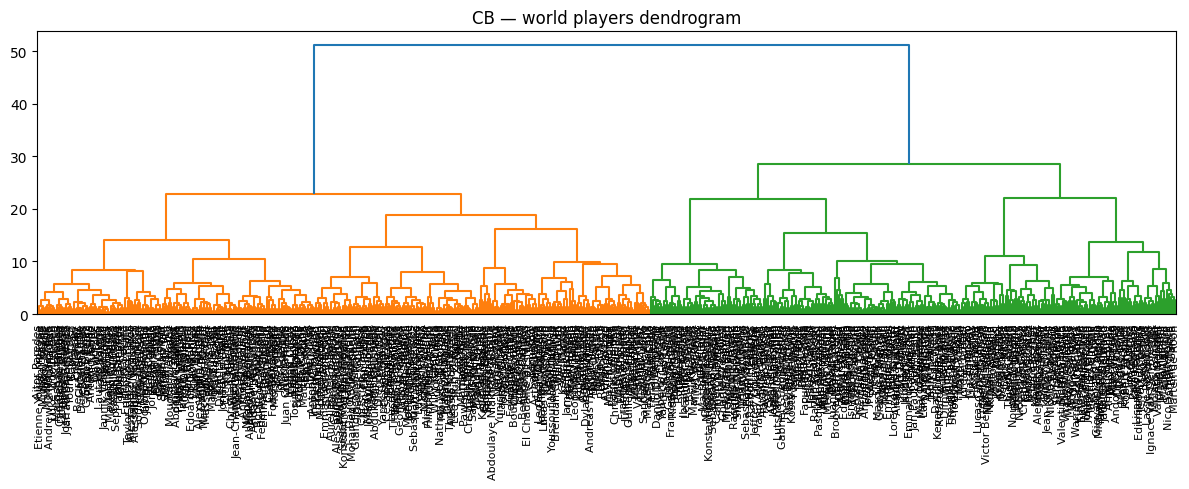


Top 5 recommendations for Arsenal — CB


,Player,Squad,SubRole,Ast_p90,KP_p90,xAG_p90,SCA90,GCA90,Tkl_p90,TklW_p90,Int_p90,Blocks_stats_defense_p90,Clr_p90,Fit_Cosine,Fit_Euclid,MinutesEvidence
0,Matteo Darmian,Inter,CB,0.101,0.758,0.076,1.72,0.20,1.414,0.859,0.505,0.707,1.970,0.931412,2.557430,19.8
1,Dimitri Foulquier,Valencia,CB,0.039,0.392,0.055,1.41,0.16,1.882,1.216,0.627,0.824,3.373,0.917367,0.880637,25.5
2,Aurélio Buta,Reims,CB,0.046,0.457,0.037,1.42,0.18,1.689,1.096,1.005,0.868,2.694,0.906564,0.862113,21.9
3,Jack Hinshelwood,Brighton,CB,0.098,0.829,0.073,1.71,0.15,1.317,0.927,0.780,0.488,1.805,0.895756,2.669518,20.5
4,Arnau Martinez,Girona,CB,0.068,0.616,0.075,1.92,0.21,1.747,0.959,1.062,0.616,2.603,0.873533,2.153608,29.2


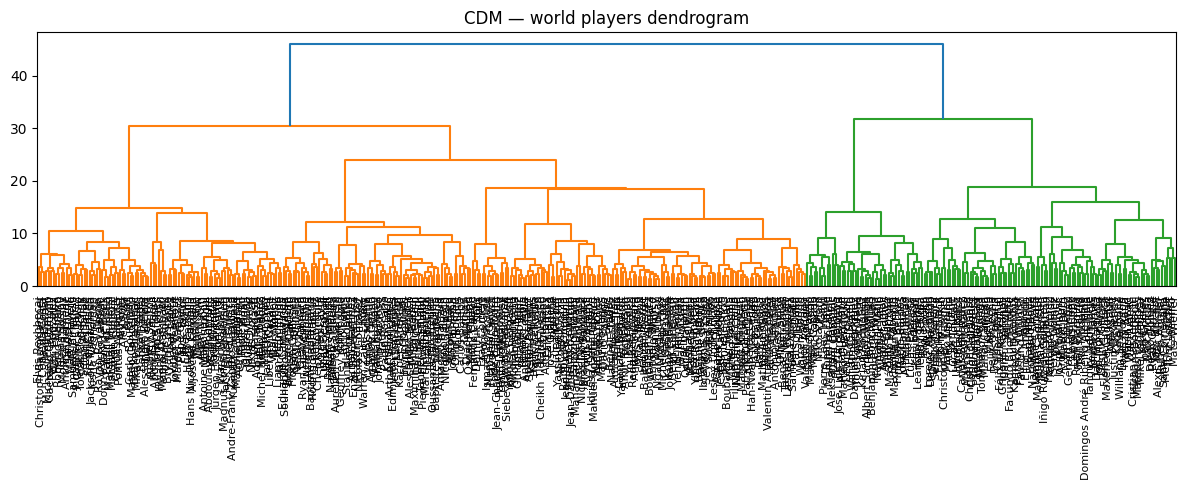


Top 5 recommendations for Arsenal — CDM


,Player,Squad,SubRole,Ast_p90,KP_p90,xAG_p90,SCA90,GCA90,Gls_p90,Tkl_p90,TklW_p90,Int_p90,Blocks_stats_defense_p90,Clr_p90,PrgP_p90,Touches_p90,1/3_p90,PPA_p90,Cmp_p90,Fit_Cosine,Fit_Euclid,MinutesEvidence
0,Koke,Atlético Madrid,CDM,0.047,0.748,0.065,2.38,0.23,0.047,2.150,1.075,0.935,1.121,1.355,6.168,85.467,6.262,1.028,67.477,0.865975,2.139470,21.4
1,Pedro Chirivella,Nantes,CDM,0.077,0.728,0.069,2.11,0.23,0.000,1.686,1.111,0.728,0.958,1.724,6.513,66.667,6.475,0.920,51.188,0.844223,2.219654,26.1
2,Kevin Kampl,RB Leipzig,CDM,0.000,0.904,0.079,2.49,0.28,0.056,1.525,1.017,1.356,1.412,1.412,5.989,74.350,4.576,1.356,59.096,0.818919,2.404270,17.7
3,André Gomes,Lille,CDM,0.000,0.704,0.049,1.83,0.07,0.000,1.901,0.915,0.423,0.493,0.775,7.113,76.479,6.761,1.056,60.634,0.800967,2.960353,14.2
4,Benjamin Bouchouari,Saint-Étienne,CDM,0.000,0.812,0.046,2.71,0.16,0.051,1.675,1.371,0.863,1.066,0.761,6.751,62.589,6.244,1.218,45.787,0.787510,2.556565,19.7


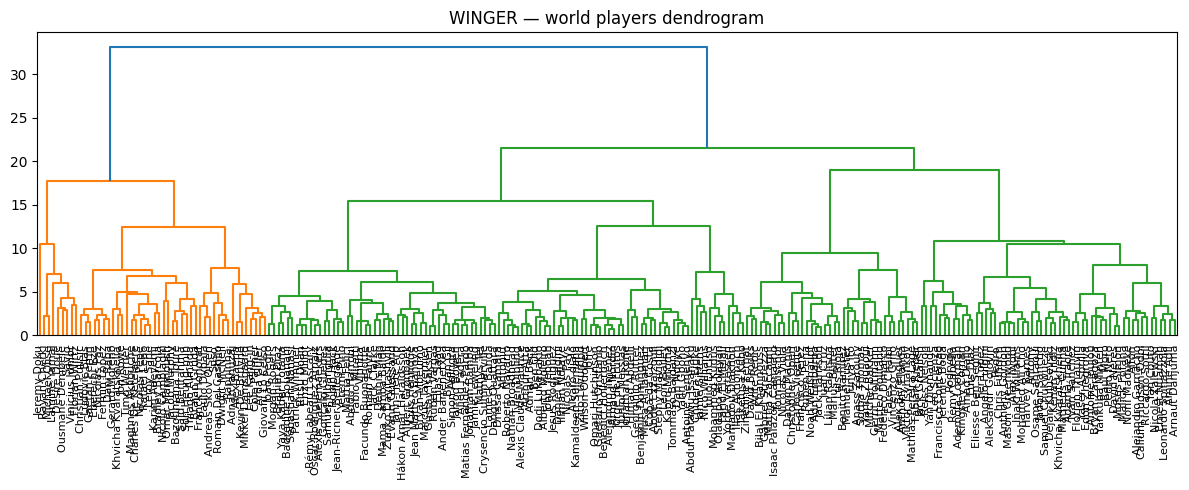


Top 5 recommendations for Arsenal — WINGER


,Player,Squad,SubRole,Ast_p90,xAG_p90,KP_p90,SCA90,GCA90,PPA_p90,TB_p90,Crs_p90,Succ_p90,Att_stats_possession_p90,PrgC_p90,Fit_Cosine,Fit_Euclid,MinutesEvidence
0,Adama Traoré,Fulham,WINGER,0.355,0.249,2.132,4.16,0.51,1.929,0.305,5.076,2.437,4.924,5.076,0.858098,1.384003,19.7
1,Bryan Zaragoza,Osasuna,WINGER,0.294,0.157,1.765,3.49,0.44,1.667,0.196,5.098,2.794,6.422,5.147,0.788652,1.723540,20.4
2,David Neres,Napoli,WINGER,0.280,0.245,1.818,4.14,0.63,1.469,0.210,6.434,2.308,5.245,5.105,0.768555,1.544194,14.3
3,Moses Simon,Nantes,WINGER,0.345,0.231,1.931,3.73,0.52,1.414,0.172,7.655,2.241,5.069,5.069,0.762222,1.919684,29.0
4,Sávio,Manchester City,WINGER,0.408,0.352,2.347,5.66,0.76,2.398,0.255,4.286,2.653,5.765,6.990,0.744520,3.791647,19.6


In [24]:

# Example: Arsenal Center Backs
ranked_cb, top5_cb = recommend_for_club_subrole("Arsenal", "CB", top_k=5, plot_tree=True)

# Example: Arsenal CDMs
ranked_cdm, top5_cdm = recommend_for_club_subrole("Arsenal", "CDM", top_k=5, plot_tree=True)

# Example: Arsenal Wingers
ranked_w, top5_w = recommend_for_club_subrole("Arsenal", "WINGER", top_k=5, plot_tree=True)
